In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import my_scripts.WiSe as WiSe
import matplotlib.pyplot as plt
import my_scripts.data_cleaning as dc
import my_scripts.TabNet_trainer as tn
import my_scripts.XGBoost_trainer as xg
import my_scripts.RidgeRegression_trainer as rr

In [5]:
df = pd.read_csv('Contact_Clean.csv')
df = df.drop(columns=['Unnamed: 0'])
target = 'VeloStars_Member__c'

# A. Feature Selection 

In [3]:
# apply univariate selection filters 
selected_pearson = WiSe.univariate_filter_spearman(df, target)
selected_spearman = WiSe.univariate_filter_spearman(df, target)
selected_univariate = list(set.union(set(selected_pearson), set(selected_spearman)))

# model selection based filtering 
selected_lasso = WiSe.model_selection_lasso(df, target, selected_univariate)
print("Remaining number of features: ", len(selected_lasso), "out of", df.shape[1] -1)

Remaining number of features:  7 out of 12


## B. Ridge Regression Predictions

Accuracy: 0.88
MCC Score: 0.40
F1 Score: 0.38


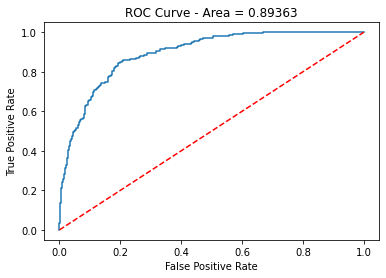

In [11]:
# trainer definition
RidgeRegression_full = rr.RidgeRegression_classifer_trainer(df, target, std=True)

# hyper-params. definiton
learning_rates = [0.001, 0.01, 0.1]
degrees = [1, 3, 5]
n_components=[5, 6, 10, 12]

# model training 
RidgeRegression_full.train_model_on_best_params(learning_rates=learning_rates, degrees=degrees, 
                                                n_components=n_components, end_evaluation=True)

Accuracy: 0.87
MCC Score: 0.34
F1 Score: 0.31


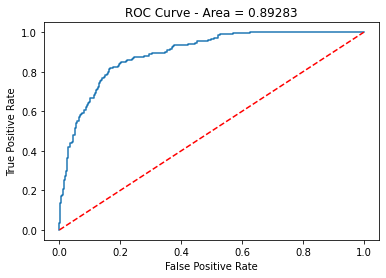

In [17]:
RidgeRegression_WiSe = rr.RidgeRegression_classifer_trainer(df, target, std=True)

learning_rates = [0.001, 0.01, 0.1]
degrees = [1, 3, 5]
n_components=[5, 7]

RidgeRegression_WiSe.train_model_on_best_params(learning_rates=learning_rates, degrees=degrees, 
                                                n_components=n_components, features=selected_lasso, end_evaluation=True)

**Final Observations:** Ridge regression, along with multiple adds-on is able to increase the AuROC score, however, not SalesForce level. 

## C. XGBoost Predictions

Best CV min score: 0.87
Accuracy: 0.90
MCC Score: 0.55
F1 Score: 0.59


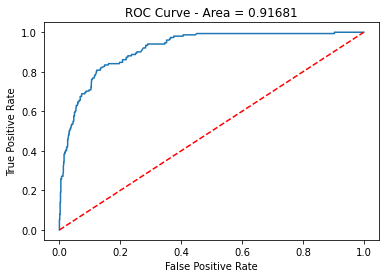

In [13]:
# trainer definiton
XGBoost_full = xg.XGBoost_classifier_trainer(df, target)

# hyper-params def. 
max_depths = [1, 2, 4, 5, 8, 10]
learning_rates = [0.001, 0.01, 0.1, 0.7]
n_estimators = [2, 3, 5, 7]

# model training
XGBoost_full.train_model_on_best_params(max_depths=max_depths, learning_rates=learning_rates, 
                                        n_estimators=n_estimators, end_evaluation=True)

Best CV min score: 0.88
Accuracy: 0.88
MCC Score: 0.49
F1 Score: 0.55


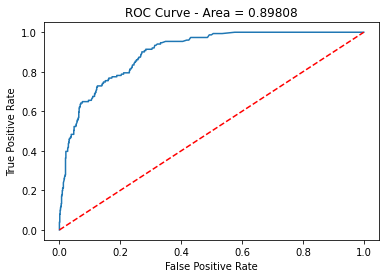

In [8]:
selected_xgboost = XGBoost_full.return_k_most_important_features(k=8)

XGBoost_selected = xg.XGBoost_classifier_trainer(df, target)
XGBoost_selected.train_model_on_best_params(max_depths=max_depths, learning_rates=learning_rates, 
                                        n_estimators=n_estimators, features=selected_xgboost, end_evaluation=True)

**Observations:** SF Einstein is able to reach great performance thanks to the techniques it uses: XGBoost is know to obtain great classification results, however, being dependent on regression trees, it also has a greater chance of overfitting. 
Furthermore, regression trees have the ability to detect features that are useless, something that was painfully done by hand in this notebook. 
However, in light of the extremely high score returned by SF, there is a great chance that the algoritm overfitted the problem.

## D. TabNet Predictions

Device used : cpu
epoch 0  | loss: 1.33501 | train_auc: 0.49758 | valid_auc: 0.49185 |  0:00:01s
epoch 1  | loss: 0.50367 | train_auc: 0.40393 | valid_auc: 0.4099  |  0:00:02s
epoch 2  | loss: 0.40699 | train_auc: 0.52368 | valid_auc: 0.57799 |  0:00:03s
epoch 3  | loss: 0.3654  | train_auc: 0.50863 | valid_auc: 0.48877 |  0:00:04s
epoch 4  | loss: 0.37748 | train_auc: 0.59056 | valid_auc: 0.57152 |  0:00:05s
epoch 5  | loss: 0.35097 | train_auc: 0.61621 | valid_auc: 0.57999 |  0:00:06s
epoch 6  | loss: 0.35414 | train_auc: 0.69001 | valid_auc: 0.67403 |  0:00:07s
epoch 7  | loss: 0.34005 | train_auc: 0.62881 | valid_auc: 0.62107 |  0:00:08s
epoch 8  | loss: 0.32186 | train_auc: 0.62832 | valid_auc: 0.60508 |  0:00:09s
epoch 9  | loss: 0.3164  | train_auc: 0.57902 | valid_auc: 0.57819 |  0:00:10s
epoch 10 | loss: 0.30948 | train_auc: 0.63298 | valid_auc: 0.60242 |  0:00:12s
epoch 11 | loss: 0.30659 | train_auc: 0.6196  | valid_auc: 0.56091 |  0:00:13s
epoch 12 | loss: 0.29794 | train_a

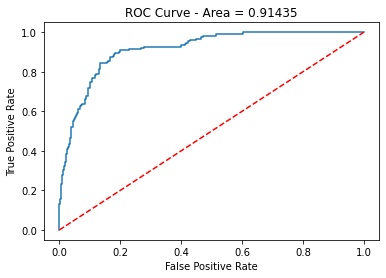

In [22]:
TabNet_full = tn.TabNet_binary_classifer_trainer(df, target, n_d=10, n_a=10, lr=0.1, lambda_sparse=1e-5)
TabNet_full.train_model(max_epochs=100, end_evaluation=True, verbose=1)

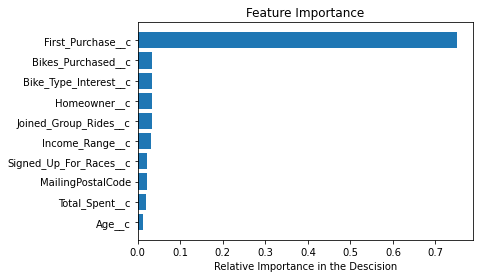

In [20]:
TabNet_full.print_feature_importance()

**Observations:** new deep learning techniques have been used (such as Google's TabNet) and could have landed similar results such as the one returned by SF. 